In [13]:
!pip install yfinance

In [14]:
# downloading S&P 500 PRICE Data

import yfinance as yf     # this package calls the yahoo finance api to download daily stock and index prices    
import pandas as pd 
import os

In [15]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")  # Ticker class enables us to download the price history for a GSPC symbol,which is the S&P 500 index
    sp500 = sp500.history(period="max") # query the historical prices
    sp500.to_csv("sp500.csv")

In [16]:
sp500.index = pd.to_datetime(sp500.index)

In [17]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-03-06 00:00:00-05:00,4055.149902,4078.489990,4044.610107,4048.419922,4000870000,0.0,0.0
2023-03-07 00:00:00-05:00,4048.260010,4050.000000,3980.310059,3986.370117,3922500000,0.0,0.0
2023-03-08 00:00:00-05:00,3987.550049,4000.409912,3969.760010,3992.010010,3535570000,0.0,0.0


<AxesSubplot:xlabel='Date'>

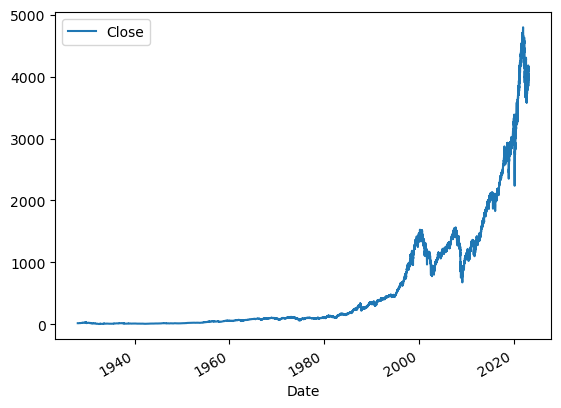

In [18]:
# Cleaning and Visualizing our stock market data

sp500.plot.line(y="Close", use_index=True)       

# x-axis => index, which is trading days
#y axis => closing price on the y axis

In [19]:
# Removing Dividends and Stock Splits column that we dont needed.

del sp500["Dividends"]
del sp500["Stock Splits"]

In [43]:
# Setting up our target for machine learning -> will the price will go up or down tomorrow.??
# create a column tommorow; in which tommorows price is there.

sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [21]:
# IS tommorow price is greater than todays price? will return a boolean. But we want it to return in integer.
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [22]:
sp500 = sp500.loc["1990-01-01":].copy()    # removing all data before 1990

In [23]:
# Training an initial machine learning model.

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

# splitting the datasets:
# all of the datarows except the last 100 rows into the training set
# and, last 100 rows into the test set.

train = sp500.iloc[:-100]          
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [24]:
# measuring the accuracy of the model!
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.38333333333333336

<AxesSubplot:xlabel='Date'>

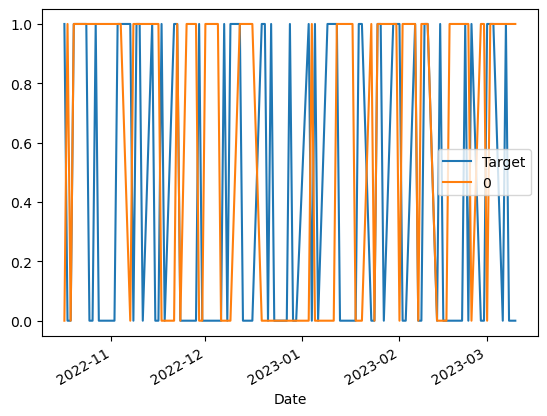

In [25]:
# concatinating our test targets which is our actual values and predicted values
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [26]:
# prediction function of what we done above:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [27]:
# BUILDING A BACKTESTING SYSTEM!!
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [28]:
predictions = backtest(sp500, model, predictors)

In [29]:
predictions["Predictions"].value_counts()

0    3404
1    2458
Name: Predictions, dtype: int64

In [30]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5276647681041498

In [31]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.533606
0    0.466394
Name: Target, dtype: float64

In [32]:
# Adding additional predictors to our model:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [33]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [34]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-06 00:00:00-05:00,4055.149902,4078.489990,4044.610107,4048.419922,4000870000,3986.370117,0,1.000343,2.0,1.012259,3.0,1.017082,29.0,1.007937,113.0,1.097462,536.0
2023-03-07 00:00:00-05:00,4048.260010,4050.000000,3980.310059,3986.370117,3922500000,3992.010010,1,0.992277,1.0,0.995937,3.0,1.001273,29.0,0.992671,113.0,1.080303,535.0
2023-03-08 00:00:00-05:00,3987.550049,4000.409912,3969.760010,3992.010010,3535570000,3918.320068,0,1.000707,1.0,0.995326,4.0,1.002570,29.0,0.994358,113.0,1.081492,536.0


In [35]:
# improving our model by increasing n_estimators to 200.
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [36]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1       # Threshold Values
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [37]:
predictions = backtest(sp500, model, new_predictors)

In [38]:
predictions["Predictions"].value_counts()

0.0    4049
1.0     813
Name: Predictions, dtype: int64

In [39]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5694956949569495

In [40]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.543603
0    0.456397
Name: Target, dtype: float64

In [41]:
predictions

,Target,Predictions
Date,,
2003-11-14 00:00:00-05:00,0,0.0
2003-11-17 00:00:00-05:00,0,1.0
2003-11-18 00:00:00-05:00,1,1.0
2003-11-19 00:00:00-05:00,0,0.0
2003-11-20 00:00:00-05:00,1,1.0
...,...,...
2023-03-06 00:00:00-05:00,0,0.0
2023-03-07 00:00:00-05:00,1,0.0
2023-03-08 00:00:00-05:00,0,0.0
